In [ ]:
import specsuite as ss
import matplotlib.pyplot as plt
import numpy as np

### _Loading Data_
Although you are able to load data using the same functions shown on other pages, there are some extra complications that GMOS-N presents during the loading process. Firstly, the FITS files produced by GMOS-N have twelve separate headers, each containing a portion of the complete readout. Secondly, the detector is comprised of three chips that are separated by a gap (~61 pixels in length). We need to represent these gaps using NaN values to prevent logical errors during the wavelength calibration, but we also need to mask those out before further analysis (since many of the processing functions were not made to handle NaN columns). Let's start by just loading in the relevant data.

In [ ]:
CAL_PATH = "../data/GMOS/calibrations"
DATA_PATH = "../data/GMOS/target"
DATA_REGION = (1750, 1950)
# DATA_REGION = (100, 300)

# Loads standard calibration images
full_bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)

full_flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="GMOS",
    crop_bds = DATA_REGION,
)

full_arc = ss.average_matching_files(
    path = "../data/GMOS/calibrations",
    tag = "CuAr",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)

# Collects individual science exposures
full_science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)

ss.plot_image(full_bias, norm='log', title="GMOS-N Bias Exposure")
ss.plot_image(full_flat, norm='log', title="GMOS-N Flatfield Exposure")
ss.plot_image(full_arc, norm='log', title="GMOS-N Arclamp (CuAr) Exposure")
ss.plot_image(full_science[0], norm='log', title="GMOS-N Science Exposure")

We can see that these "chip gaps" appear as entirely white columns in our data. For data that looks like this, it is often simplest to split up each chip and process them individually. For simplicity, we will only process data from the rightmost chip.

In [ ]:
chip_idx = 0

# Only keeps data from the rightmost chip
arc = ss.split_chips(full_arc)[0][chip_idx]
bias = ss.split_chips(full_bias)[0][chip_idx]
flat = ss.split_chips(full_flat)[0][chip_idx]
science = ss.split_chips(full_science)[:, chip_idx]

ss.plot_image(bias, norm='log', title="GMOS-N Bias Exposure")
ss.plot_image(flat, norm='log', title="GMOS-N Flatfield Exposure")
ss.plot_image(arc, norm='log', title="GMOS-N Arclamp (CuAr) Exposure")
ss.plot_image(science[0], norm='log', title="GMOS-N Science Exposure")

### _Standard Calibrations_

In [ ]:
# Subtracts off bias from all exposures
arc -= bias
flat -= bias
science -= bias

# Performs a flatfield correction for all science exposures
science = ss.flatfield_correction(
    image = science,
    flat = flat,
    debug = True,
)

### _Background Extraction_
Next, we will generate a __warp model__ to use in a background extraction. Since GMOS-N is a fairly sensitive instrument, the threshold needed to identify line emissions in our arclamp exposure is much lower. A value of 6 works pretty well!

In [ ]:
locs, _ = ss.find_cal_lines(
    image = arc,
    std_variation = 6,
    debug = True,
)

warp_model = ss.generate_warp_model(
    image = arc,
    guess = locs,
    debug = True,
)

We can see that the white grid seems to do a good job tracing out the shape of line emissions in our arclamp exposure, so our warp model is reasonably accurate! Let's go ahead and extract the background from our science exposures...

In [ ]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (75, 150),
    update = True,
)

It can be helpful to double-check that the extracted background looks reasonable!

In [ ]:
KWARGS = {"vmin": 1e2, "vmax": 3e4}

ss.plot_image(science[0], norm='log', **KWARGS)
ss.plot_image(backgrounds[0], norm='log', **KWARGS)
ss.plot_image(science[0] - backgrounds[0], norm='log', **KWARGS)

Since the region of the image that our target does not illuminate looks like random static, we can be reasonably certain that our background extraction is accurate!

### Flux Extraction

In [ ]:
flux, error = ss.boxcar_extraction(
    science = science - backgrounds,
    backgrounds = backgrounds,
    RN = 10.0,
)

boxcar_flux = np.median(flux, axis=0)
boxcar_error = np.max(error, axis=0)

xs = np.array(range(len(boxcar_flux)))
plt.errorbar(xs, boxcar_flux, yerr=boxcar_error, color='k')
plt.xlim(min(xs), max(xs))
plt.yscale("log")
plt.show()

In [ ]:
flux, error = ss.horne_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
)

horne_flux = np.median(flux, axis=1)
horne_error = np.max(error, axis=1)

xs = np.array(range(len(horne_flux)))
plt.errorbar(xs, horne_flux, yerr=horne_error, color='k')
plt.xlim(min(xs), max(xs))
plt.yscale("log")
plt.show()

In [ ]:
horne_SNR = np.abs(horne_flux/horne_error)
boxcar_SNR = np.abs(boxcar_flux/boxcar_error)

plt.plot(xs, horne_SNR/boxcar_SNR)
plt.ylim(0.8, 4.0)

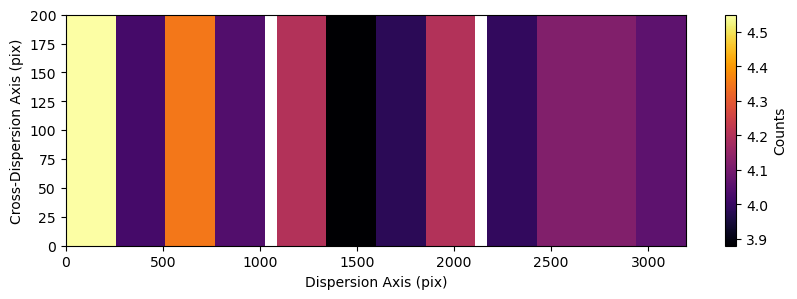

[[4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]
 [4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]
 [4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]
 ...
 [4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]
 [4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]
 [4.55000019 4.55000019 4.55000019 ... 4.05999994 4.05999994 4.05999994]]


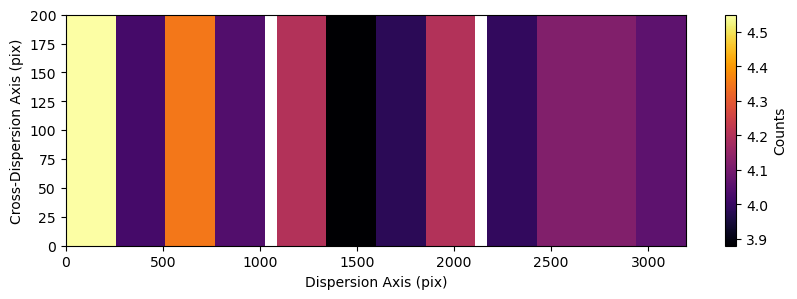

Performing Optimal Extraction:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

In [ ]:
_, RN_image_full = ss.loading._GMOS_loader(
    path = "../data/GMOS/target",
    file = "toi3884.0017.fits",
    return_RN = True,
)

RN_image_full = RN_image_full[DATA_REGION[0]:DATA_REGION[1]]

for chip_idx in range(3):

    # Pulls the data for a single chip
    arc = ss.split_chips(full_arc)[0][chip_idx]
    bias = ss.split_chips(full_bias)[0][chip_idx]
    flat = ss.split_chips(full_flat)[0][chip_idx]
    science = ss.split_chips(full_science)[:, chip_idx]

    RN = ss.split_chips(RN_image_full)[0][chip_idx]

    # Subtracts off bias from all exposures
    arc -= bias
    flat -= bias
    science -= bias

    # Performs a flatfield correction for all science exposures
    science = ss.flatfield_correction(
        image = science,
        flat = flat,
    )

    # Constructs a warp model using the arclamp exposure
    locs, _ = ss.find_cal_lines(
        image = arc,
        std_variation = 6,
    )
    warp_model = ss.generate_warp_model(
        image = arc,
        guess = locs,
    )

    # Extracts the background emissions
    backgrounds = ss.extract_background(
        images = science,
        warp_model = warp_model,
        mask_region = (75, 150),
    )

    # Performs and Horne extraction to all images
    flux, error = ss.horne_extraction(
        images = science - backgrounds,
        backgrounds = backgrounds,
        RN = RN,
        update = True,
    )
    horne_flux = np.median(flux, axis=1)
    horne_error = np.max(error, axis=1)

    # Performs and Horne extraction to all images
    flux, error = ss.boxcar_extraction(
        science = science - backgrounds,
        backgrounds = backgrounds,
        RN = RN,
    )
    boxcar_flux = np.median(flux, axis=0)
    boxcar_error = np.max(error, axis=0)

    # Determines the pixel locations for each chip
    xs = np.array(range(len(horne_flux)))
    if chip_idx == 1:
        xs += 61 + len(xs)
    if chip_idx ==2:
        xs += 2*61 + 2*len(xs)

    # plt.errorbar(xs[10:-10], horne_flux[10:-10], yerr=horne_error[10:-10], color='k')
    plt.plot(xs, horne_flux/horne_error, label="Horne Extraction", color='black')
    plt.plot(xs, boxcar_flux/boxcar_error, label="Boxcar Extraction", color='red')
# plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
_, RN_image_full = ss.loading._GMOS_loader(
    path = "../data/GMOS/target",
    file = "toi3884.0017.fits",
    return_RN = True,
)

print(RN_image_full)
ss.plot_image(RN_image_full)

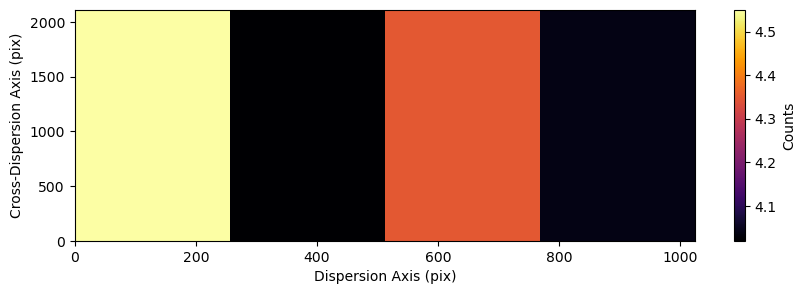

(2112, 1024)


In [21]:
ss.plot_image(RN)

print(RN.shape)

flux, error = ss.boxcar_extraction(
    science = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
)